# Prediktivni model za prometne nesreće
## Klasifikacija težine nesreće (Accident Severity)

In [1]:
# Učitavanje potrebnih biblioteka za modeliranje
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

# Učitavanje podataka
df_model = pd.read_csv('./RTA Dataset.csv')

print(f"Ukupan broj zapisa: {df_model.shape[0]}")
print(f"Ukupan broj značajki: {df_model.shape[1]}")
print(f"\nRaspodjela ciljne varijable (Accident_severity):")
print(df_model['Accident_severity'].value_counts())

Ukupan broj zapisa: 12316
Ukupan broj značajki: 32

Raspodjela ciljne varijable (Accident_severity):
Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


In [2]:
# Priprema podataka za modeliranje
# Odabir relevantnih značajki (isključujemo ciljnu varijablu i nepotrebne stupce)

# Značajke koje ćemo koristiti
features_to_use = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties', 'Vehicle_movement',
    'Cause_of_accident'
]

# Stvaranje kopije dataseta samo s odabranim značajkama
df_features = df_model[features_to_use].copy()
y = df_model['Accident_severity'].copy()

print("Odabrane značajke za model:")
for i, feat in enumerate(features_to_use, 1):
    print(f"  {i}. {feat}")

Odabrane značajke za model:
  1. Day_of_week
  2. Age_band_of_driver
  3. Sex_of_driver
  4. Educational_level
  5. Driving_experience
  6. Type_of_vehicle
  7. Owner_of_vehicle
  8. Area_accident_occured
  9. Lanes_or_Medians
  10. Road_allignment
  11. Types_of_Junction
  12. Road_surface_type
  13. Road_surface_conditions
  14. Light_conditions
  15. Weather_conditions
  16. Type_of_collision
  17. Number_of_vehicles_involved
  18. Number_of_casualties
  19. Vehicle_movement
  20. Cause_of_accident


In [3]:
# Obrada nedostajućih vrijednosti
print("Nedostajuće vrijednosti prije obrade:")
missing_before = df_features.isnull().sum()
print(missing_before[missing_before > 0])

# Popunjavanje nedostajućih vrijednosti s 'Unknown' za kategoričke varijable
for col in df_features.columns:
    if pd.api.types.is_numeric_dtype(df_features[col]):
        df_features[col] = df_features[col].fillna(df_features[col].median())
    else:
        df_features[col] = df_features[col].fillna('Unknown')

print("\nNedostajuće vrijednosti nakon obrade:")
print(df_features.isnull().sum().sum())

Nedostajuće vrijednosti prije obrade:
Educational_level        741
Driving_experience       829
Type_of_vehicle          950
Owner_of_vehicle         482
Area_accident_occured    239
Lanes_or_Medians         385
Road_allignment          142
Types_of_Junction        887
Road_surface_type        172
Type_of_collision        155
Vehicle_movement         308
dtype: int64

Nedostajuće vrijednosti nakon obrade:
0


In [4]:
# Label Encoding za sve kategoričke varijable
label_encoders = {}
df_encoded = df_features.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Enkodiranje ciljne varijable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("Mapiranje ciljne varijable:")
for i, cls in enumerate(le_target.classes_):
    print(f"  {cls} -> {i}")

print(f"\nDimenzije podataka: {df_encoded.shape}")

Mapiranje ciljne varijable:
  Fatal injury -> 0
  Serious Injury -> 1
  Slight Injury -> 2

Dimenzije podataka: (12316, 20)


In [5]:
# Podjela podataka na trening i test skupove
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Osigurava jednaku raspodjelu klasa
)

print(f"Veličina trening skupa: {X_train.shape[0]} ({X_train.shape[0]/len(df_encoded)*100:.1f}%)")
print(f"Veličina test skupa: {X_test.shape[0]} ({X_test.shape[0]/len(df_encoded)*100:.1f}%)")

print(f"\nRaspodjela klasa u trening skupu:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le_target.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Veličina trening skupa: 9852 (80.0%)
Veličina test skupa: 2464 (20.0%)

Raspodjela klasa u trening skupu:
  Fatal injury: 127 (1.3%)
  Serious Injury: 1394 (14.1%)
  Slight Injury: 8331 (84.6%)


In [6]:
# Treniranje Random Forest klasifikatora
print("Treniranje Random Forest modela...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Balansira neravnotežu klasa
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predikcija na test skupu
y_pred_rf = rf_model.predict(X_test)

print("Random Forest model uspješno treniran!")
print(f"\nTočnost na trening skupu: {rf_model.score(X_train, y_train)*100:.2f}%")
print(f"Točnost na test skupu: {rf_model.score(X_test, y_test)*100:.2f}%")

Treniranje Random Forest modela...
Random Forest model uspješno treniran!

Točnost na trening skupu: 98.22%
Točnost na test skupu: 83.97%


In [7]:
# Detaljno izvješće o klasifikaciji
print("=" * 60)
print("IZVJEŠĆE O KLASIFIKACIJI - Random Forest")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le_target.classes_))

# Dodatne metrike
print("\nDodatne metrike:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  Macro F1-Score: {f1_score(y_test, y_pred_rf, average='macro')*100:.2f}%")
print(f"  Weighted F1-Score: {f1_score(y_test, y_pred_rf, average='weighted')*100:.2f}%")

IZVJEŠĆE O KLASIFIKACIJI - Random Forest

Classification Report:
                precision    recall  f1-score   support

  Fatal injury       0.43      0.10      0.16        31
Serious Injury       0.39      0.07      0.12       349
 Slight Injury       0.85      0.98      0.91      2084

      accuracy                           0.84      2464
     macro avg       0.56      0.38      0.40      2464
  weighted avg       0.78      0.84      0.79      2464


Dodatne metrike:
  Accuracy: 83.97%
  Macro F1-Score: 39.83%
  Weighted F1-Score: 79.10%


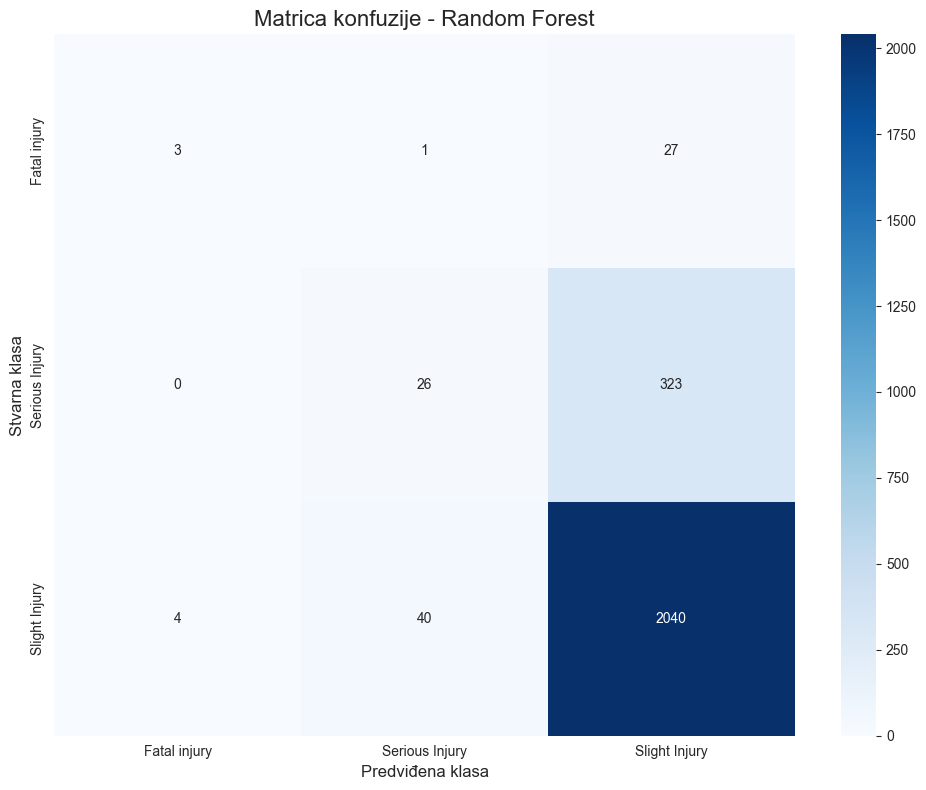

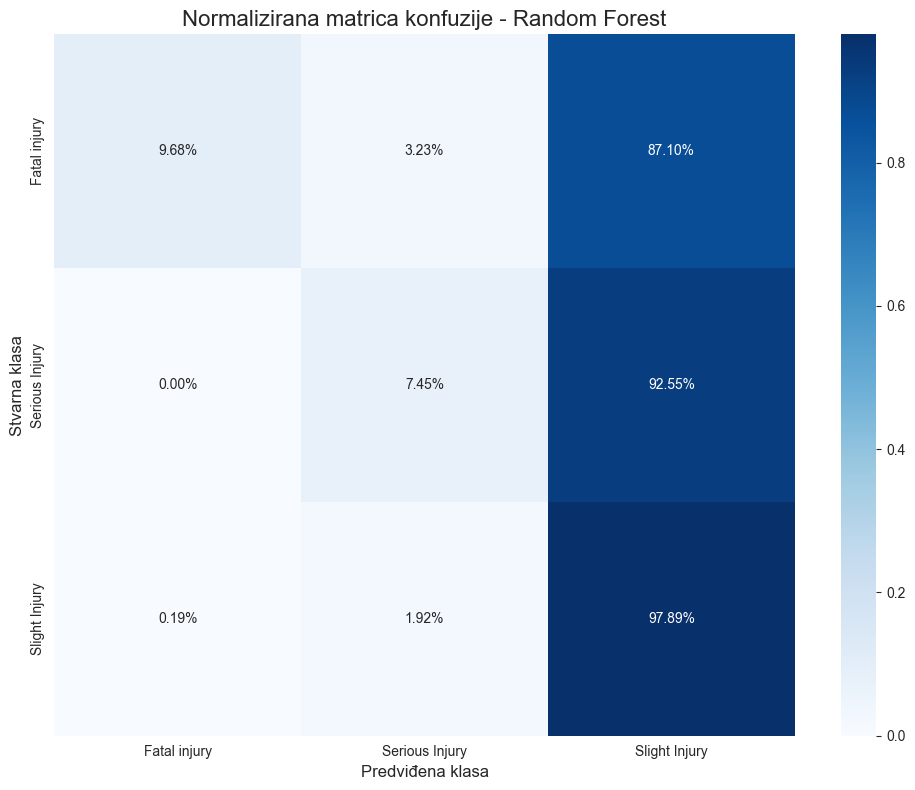

In [8]:
# Vizualizacija matrice konfuzije
plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_rf)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)

plt.title('Matrica konfuzije - Random Forest', fontsize=16)
plt.xlabel('Predviđena klasa', fontsize=12)
plt.ylabel('Stvarna klasa', fontsize=12)
plt.tight_layout()
plt.show()

# Normalizirana matrica konfuzije
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)

plt.title('Normalizirana matrica konfuzije - Random Forest', fontsize=16)
plt.xlabel('Predviđena klasa', fontsize=12)
plt.ylabel('Stvarna klasa', fontsize=12)
plt.tight_layout()
plt.show()

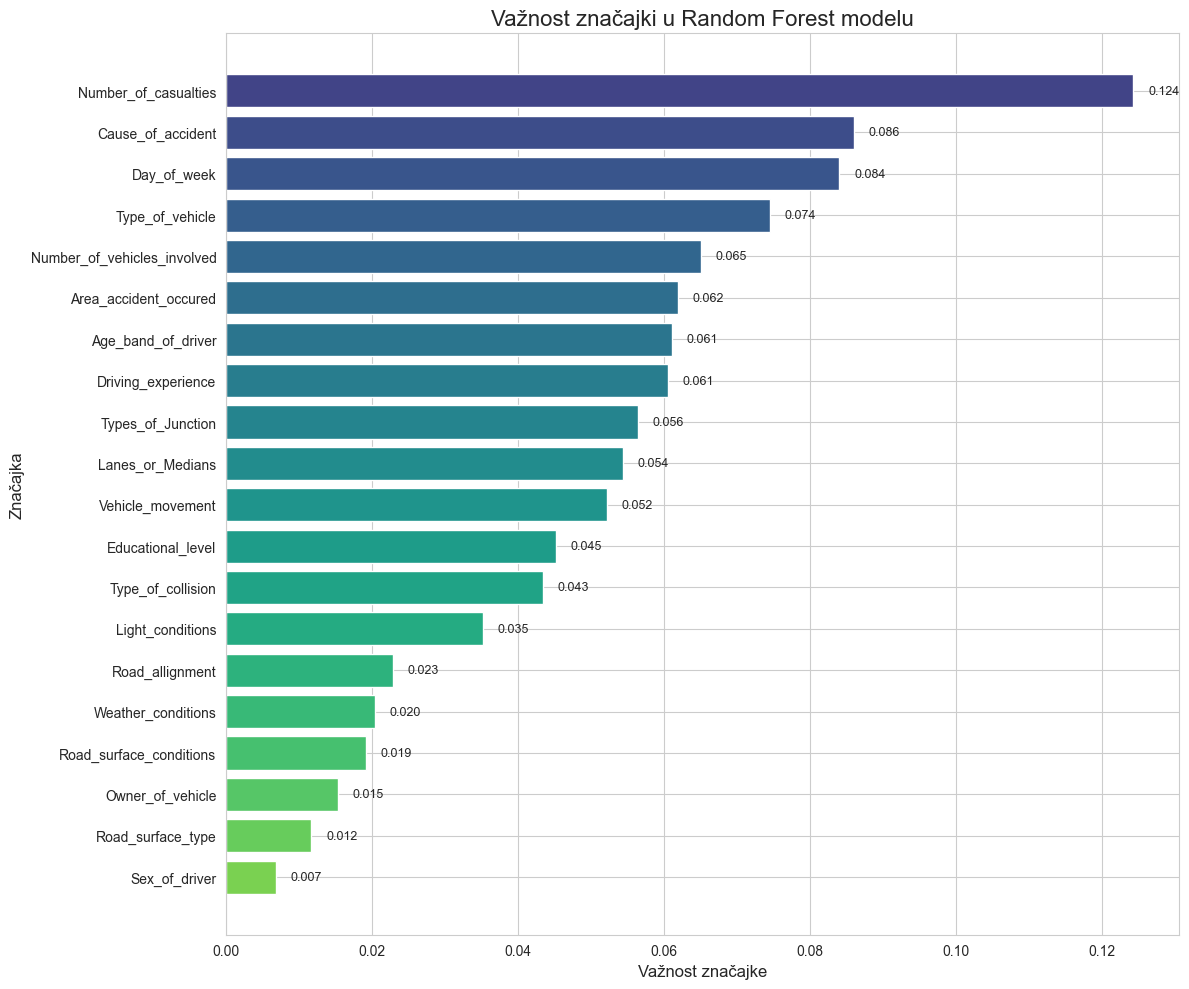


Top 10 najvažnijih značajki:
                   Značajka  Važnost
       Number_of_casualties 0.124256
          Cause_of_accident 0.086023
                Day_of_week 0.083997
            Type_of_vehicle 0.074428
Number_of_vehicles_involved 0.065074
      Area_accident_occured 0.061842
         Age_band_of_driver 0.061098
         Driving_experience 0.060557
          Types_of_Junction 0.056438
           Lanes_or_Medians 0.054317


In [9]:
# Važnost značajki (Feature Importance)
feature_importance = pd.DataFrame({
    'Značajka': df_encoded.columns,
    'Važnost': rf_model.feature_importances_
}).sort_values('Važnost', ascending=False)

plt.figure(figsize=(12, 10))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))

bars = plt.barh(feature_importance['Značajka'], feature_importance['Važnost'], color=colors)
plt.xlabel('Važnost značajke', fontsize=12)
plt.ylabel('Značajka', fontsize=12)
plt.title('Važnost značajki u Random Forest modelu', fontsize=16)
plt.gca().invert_yaxis()

# Dodavanje vrijednosti na stupce
for bar, val in zip(bars, feature_importance['Važnost']):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 10 najvažnijih značajki:")
print(feature_importance.head(10).to_string(index=False))

In [10]:
# Usporedba više modela
print("Usporedba različitih klasifikacijskih modela...")
print("=" * 60)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, 
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                                     random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', 
                                               random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    print(f"\nTreniranje: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted
    })
    
    print(f"  Accuracy: {acc*100:.2f}%")
    print(f"  F1 Macro: {f1_macro*100:.2f}%")
    print(f"  F1 Weighted: {f1_weighted*100:.2f}%")

results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("USPOREDBA MODELA:")
print(results_df.to_string(index=False))

Usporedba različitih klasifikacijskih modela...

Treniranje: Random Forest...
  Accuracy: 84.33%
  F1 Macro: 34.51%
  F1 Weighted: 78.32%

Treniranje: Gradient Boosting...
  Accuracy: 85.02%
  F1 Macro: 38.81%
  F1 Weighted: 79.62%

Treniranje: Logistic Regression...
  Accuracy: 48.99%
  F1 Macro: 30.04%
  F1 Weighted: 58.18%

USPOREDBA MODELA:
              Model  Accuracy  F1 Macro  F1 Weighted
      Random Forest  0.843344  0.345110     0.783223
  Gradient Boosting  0.850244  0.388091     0.796188
Logistic Regression  0.489854  0.300449     0.581777


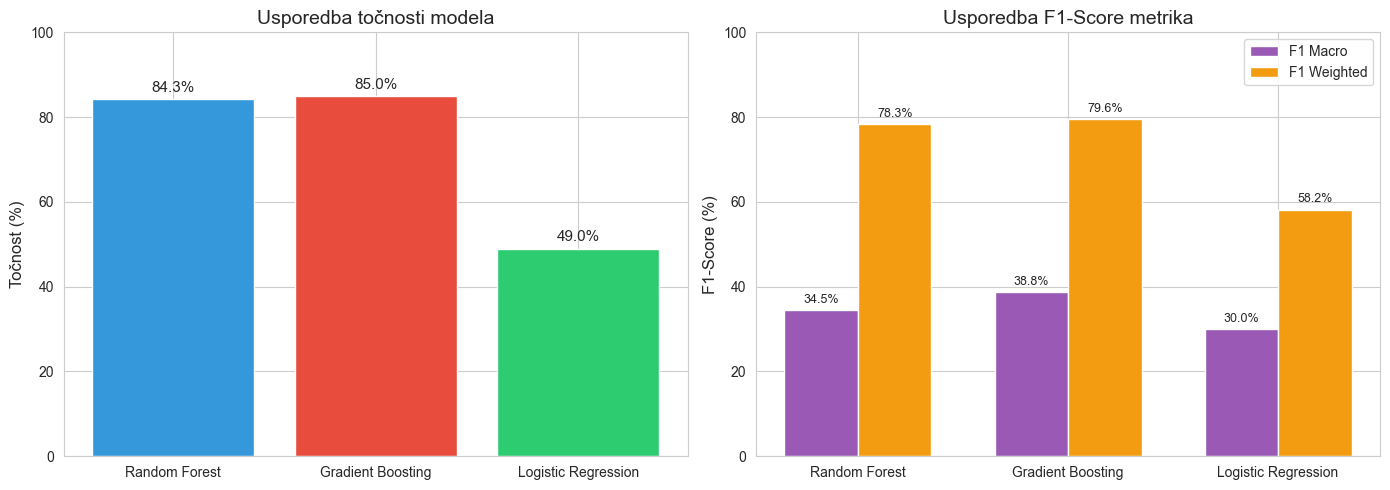

In [11]:
# Vizualizacija usporedbe modela
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graf točnosti
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars1 = ax1.bar(results_df['Model'], results_df['Accuracy'] * 100, color=colors)
ax1.set_ylabel('Točnost (%)', fontsize=12)
ax1.set_title('Usporedba točnosti modela', fontsize=14)
ax1.set_ylim(0, 100)

for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

# Graf F1-score
ax2 = axes[1]
x = np.arange(len(results_df['Model']))
width = 0.35

bars2 = ax2.bar(x - width/2, results_df['F1 Macro'] * 100, width, label='F1 Macro', color='#9b59b6')
bars3 = ax2.bar(x + width/2, results_df['F1 Weighted'] * 100, width, label='F1 Weighted', color='#f39c12')

ax2.set_ylabel('F1-Score (%)', fontsize=12)
ax2.set_title('Usporedba F1-Score metrika', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'])
ax2.legend()
ax2.set_ylim(0, 100)

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [12]:
# Cross-validacija za najbolji model (Random Forest)
print("Cross-validacija za Random Forest model...")
print("=" * 60)

cv_scores = cross_val_score(rf_model, df_encoded, y_encoded, cv=5, scoring='accuracy')

print(f"\nRezultati 5-fold cross-validacije:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")

print(f"\nProsječna točnost: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*2*100:.2f}%)")
print(f"Standardna devijacija: {cv_scores.std()*100:.2f}%")

Cross-validacija za Random Forest model...

Rezultati 5-fold cross-validacije:
  Fold 1: 83.40%
  Fold 2: 82.38%
  Fold 3: 83.19%
  Fold 4: 83.80%
  Fold 5: 84.08%

Prosječna točnost: 83.37% (+/- 1.17%)
Standardna devijacija: 0.58%


In [13]:
# Funkcija za predikciju nove nesreće
def predict_accident_severity(input_data):
    """
    Predviđanje težine nesreće na temelju ulaznih podataka.
    
    Parameters:
    -----------
    input_data : dict
        Rječnik s vrijednostima značajki
    
    Returns:
    --------
    str : Predviđena težina nesreće
    """
    # Kreiranje DataFrame-a od ulaznih podataka
    input_df = pd.DataFrame([input_data])
    
    # Popunjavanje nedostajućih stupaca
    for col in df_encoded.columns:
        if col not in input_df.columns:
            input_df[col] = 'Unknown' if col in label_encoders else 0
    
    # Enkodiranje ulaznih podataka
    for col in input_df.columns:
        if col in label_encoders:
            le = label_encoders[col]
            try:
                input_df[col] = le.transform(input_df[col].astype(str))
            except ValueError:
                # Ako vrijednost nije poznata, koristi najčešću
                input_df[col] = 0
    
    # Osiguravanje ispravnog redoslijeda stupaca
    input_df = input_df[df_encoded.columns]
    
    # Predikcija
    prediction = rf_model.predict(input_df)
    probability = rf_model.predict_proba(input_df)
    
    predicted_class = le_target.inverse_transform(prediction)[0]
    
    return predicted_class, probability[0]

# Primjer predikcije
primjer = {
    'Day_of_week': 'Friday',
    'Age_band_of_driver': '18-30',
    'Sex_of_driver': 'Male',
    'Educational_level': 'High school',
    'Driving_experience': '2-5yr',
    'Type_of_vehicle': 'Automobile',
    'Owner_of_vehicle': 'Owner',
    'Area_accident_occured': 'Residential areas',
    'Lanes_or_Medians': 'Undivided Two way',
    'Road_allignment': 'Tangent road with flat terrain',
    'Types_of_Junction': 'No junction',
    'Road_surface_type': 'Asphalt roads',
    'Road_surface_conditions': 'Dry',
    'Light_conditions': 'Daylight',
    'Weather_conditions': 'Normal',
    'Type_of_collision': 'Vehicle with vehicle collision',
    'Number_of_vehicles_involved': 2,
    'Number_of_casualties': 1,
    'Vehicle_movement': 'Going straight',
    'Cause_of_accident': 'No distancing'
}

pred_class, pred_prob = predict_accident_severity(primjer)

print("=" * 60)
print("PRIMJER PREDIKCIJE")
print("=" * 60)
print(f"\nPredviđena težina nesreće: {pred_class}")
print(f"\nVjerojatnosti po klasama:")
for cls, prob in zip(le_target.classes_, pred_prob):
    print(f"  {cls}: {prob*100:.2f}%")

PRIMJER PREDIKCIJE

Predviđena težina nesreće: Slight Injury

Vjerojatnosti po klasama:
  Fatal injury: 4.84%
  Serious Injury: 40.32%
  Slight Injury: 54.83%


In [14]:
# Spremanje modela za kasniju upotrebu
import joblib

# Spremanje modela i encodera
joblib.dump(rf_model, 'accident_severity_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(le_target, 'target_encoder.pkl')

print("Model i encoderi uspješno spremljeni!")
print("\nDatoteke:")
print("  - accident_severity_model.pkl (Random Forest model)")
print("  - label_encoders.pkl (Encoderi za značajke)")
print("  - target_encoder.pkl (Encoder za ciljnu varijablu)")

Model i encoderi uspješno spremljeni!

Datoteke:
  - accident_severity_model.pkl (Random Forest model)
  - label_encoders.pkl (Encoderi za značajke)
  - target_encoder.pkl (Encoder za ciljnu varijablu)


## Zaključak prediktivnog modela

### Korišteni modeli:
1. **Random Forest** - Ansambl metoda s više stabala odlučivanja
2. **Gradient Boosting** - Sekvencijalno učenje slabih klasifikatora
3. **Logistic Regression** - Linearni model za klasifikaciju

### Najvažnije značajke za predikciju težine nesreće:
- Uzrok nesreće (Cause_of_accident)
- Broj stradalih (Number_of_casualties)
- Tip sudara (Type_of_collision)
- Vrsta vozila (Type_of_vehicle)
- Vozačko iskustvo (Driving_experience)

### Napomene:
- Dataset ima nebalansiranu distribuciju klasa (većina nesreća su "Slight Injury")
- Korišten je `class_weight='balanced'` za kompenzaciju neravnoteže
- Model se može poboljšati s više podataka i dodatnim značajkama